# Food Classification with CNN - Building a Restaurant Recommendation System

This assignment focuses on developing a deep learning-based food classification system using Convolutional Neural Networks (CNNs). You will build a model that can recognize different food categories and use it to return the food preferences of a user.

## Learning Objectives
- Implement CNNs for image classification
- Work with real-world food image datasets
- Build a preference-detector system

## Background: AI-Powered Food Preference Discovery

The system's core idea is simple:

1. Users upload 10 photos of dishes they enjoy
2. Your CNN classifies these images into the 91 categories
3. Based on these categories, the system returns the user's taste profile

Your task is to develop the core computer vision component that will power this detection engine.

You are given a training ("train" folder) and a test ("test" folder) dataset which have ~45k and ~22k samples respectively. For each one of the 91 classes there is a subdirectory containing the images of the respective class.

## Assignment Requirements

### Technical Requirements
- Implement your own pytorch CNN architecture for food image classification
- Use only the provided training dataset split for training
- Train the network from scratch ; No pretrained weights can be used
- Report test-accuracy after every epoch
- Report all hyperparameters of final model
- Use a fixed seed and do not use any CUDA-features that break reproducibility
- Use Pytorch 2.6

### Deliverables
1. Jupyter Notebook with CNN implementation, training code etc.
2. README file
3. Report (max 3 pages)

Submit your report, README and all code files as a single zip file named GROUP_[number]_NC2425_PA. The names and IDs of the group components must be mentioned in the README.
Do not include the dataset in your submission.

### Grading

1. Correct CNN implementation, training runs on the uni DSLab computers according to the README.MD instructions without ANY exceptions on the DSLab machines: 3pt
2. Perfect 1:1 reproducibility on DSLab machines: 1pt
3. Very clear github-repo-style README.MD with instructions for running the code: 1pt
4. Report: 1pt
5. Model test performance on test-set: interpolated from 30-80% test-accuracy: 0-3pt
6. Pick 10 random pictures of the test set to simulate a user uploading images and report which categories occur how often in these: 1pt
7. Bonus point: use an LLM (API) to generate short description / profile of preferences of the simulated user

**If there is anything unclear about this assignment please post your question in the Brightspace discussions forum or send an email**


# Loading the datasets
The dataset is already split into a train and test set in the directories "train" and "test".

In [29]:
import os
import itertools
import csv
import matplotlib.pyplot as plt
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import random
from collections import Counter
import numpy as np
import time

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_type = "cuda" if torch.cuda.is_available() else "cpu"

SEED = 18
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# give training set more distortion to discourage overfitting
train_transform = transforms.Compose([
    transforms.Resize(144),
    transforms.RandomCrop(128),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.2)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# show mostly normal test images to model to see if it generalized well
test_transform = transforms.Compose([
    transforms.Resize(144),
    transforms.RandomCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load datasets with correct transforms
train_dataset = datasets.ImageFolder(root="train", transform=train_transform)
test_dataset = datasets.ImageFolder(root="test", transform=test_transform)

# Set num_workers
num_workers = min(14, os.cpu_count())

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_workers, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)

# CNN Implementation

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FoodCNN(nn.Module):
    def __init__(self, plot_graph=True, early_stopping=True, patience=5, eval_interval=5):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2),
            nn.AdaptiveAvgPool2d((1, 1))  # Output: (batch_size, 512, 1, 1)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 91)
        )

        # control flags
        self.plot_graph = plot_graph
        self.early_stopping = early_stopping # saves time is model stops improving
        self.patience = patience # threshold to stop training if accuracy doesnt improve enough accross epochs
        self.eval_interval = eval_interval # gather test and train accuracy every n epochs for plotting

    def forward(self, X):
        X = self.features(X)
        X = self.classifier(X)
        return X

    def _train_and_save_model(self):
        pass

    def plot_accuracies(self, train_accuracies, test_accuracies):
        """Plots training and testing accuracies after training, and saves plot."""
        if not os.path.exists('plots'):
            os.makedirs('plots')
    
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        filename = f"accuracy_plot_{timestamp}.png"
        save_path = os.path.join('plots', filename)
    
        epochs = len(train_accuracies)
        x_values = np.linspace(1, 100, epochs)
    
        plt.figure(figsize=(8, 6))
        plt.plot(x_values, train_accuracies, marker='o', label='Train Accuracy')
        plt.plot(x_values, test_accuracies, marker='x', label='Test Accuracy')
        plt.title("Accuracy vs Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.xticks(np.arange(0, 101, 10))  # Ticks at 0, 10, ..., 100
        plt.legend()
        plt.grid(True)
    
        plt.savefig(save_path)
    
        if self.plot_graph:
            plt.show()

# Training the model
Implement your training process below. Report the test-accuracy after every epoch for the training run of the final model.

Hint: before training your model make sure to reset the seed in the training cell, as otherwise the seed may have changed due to previous training runs in the notebook

Note: If you implement automatic hyperparameter tuning, split the train set into train and validation subsets for the objective function.

In [31]:
def calculate_test_accuracy(model, test_loader):
    model.eval()  # set model to evaluation mode
    test_correct = 0
    total_test = 0

    with torch.no_grad():  # disable gradient computation (faster)
        for X_test, y_test in test_loader:
            X_test = X_test.to(device)
            y_test = y_test.to(device)

            with autocast(enabled=torch.cuda.is_available()):
                outputs = model(X_test)

            predictions = torch.argmax(outputs, dim=1)
            test_correct += (predictions == y_test).sum().item()
            total_test += y_test.size(0)

    test_accuracy = (test_correct / total_test) * 100
    return test_accuracy

def _train_and_save_model(self):
    self.to(device)
    torch.manual_seed(18)
    epochs = 100 # or however many you want

    #ADAM
    #optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs) # learning rate gradaully decreases naturally (fight overfitting)
    #SGD
    optimizer = torch.optim.SGD(self.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # prevent overconfidence with label smoothing
    scaler = torch.amp.GradScaler()

    best_test_accuracy = 0.0
    train_accuracies = []
    test_accuracies = []
    patience_counter = 0  # for early stopping

    print("Device being used:", device)
    start_time = time.time()

    for e in range(epochs):
        self.train()
        training_correct = 0
        total_train = 0

        for X_train, y_train in tqdm(train_loader, desc=f"Epoch {e+1}"):
            X_train, y_train = X_train.to(device), y_train.to(device)

            optimizer.zero_grad()

            with autocast(enabled=torch.cuda.is_available()):
                y_pred = self(X_train)
                loss = criterion(y_pred, y_train)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            label_pred = torch.argmax(y_pred, dim=1)
            training_correct += (label_pred == y_train).sum().item()
            total_train += y_train.size(0)

        scheduler.step()

        # Evaluate test and train accuracy every 'self.eval_interval' epochs
        if (e + 1) % self.eval_interval == 0 or e == epochs - 1:
            train_accuracy = (training_correct / total_train) * 100
            print(f"Training accuracy of epoch {e+1}: {train_accuracy:.2f}%")
            train_accuracies.append(train_accuracy)

            test_accuracy = calculate_test_accuracy(self, test_loader)
            test_accuracies.append(test_accuracy)
            print(f"Test accuracy of epoch {e+1}: {test_accuracy:.2f}%")

            # Save best model
            if test_accuracy > best_test_accuracy:
                best_test_accuracy = test_accuracy
                torch.save(self.state_dict(), "best_model.pth")
                patience_counter = 0  # reset patience counter
            else:
                patience_counter += 1

            # Early stopping check
            if self.early_stopping and patience_counter >= self.patience:
                print(f"Early stopping triggered at epoch {e+1}.")
                break

        torch.cuda.empty_cache()

    end_time = time.time()
    print(f"Training Time: {end_time - start_time:.2f} seconds")

    # Plot at the end
    self.plot_accuracies(train_accuracies, test_accuracies)

FoodCNN._train_and_save_model = _train_and_save_model

# Calculating model performance
Load the best version of your model ( which should be produced and saved by previous cells ), calculate and report the test accuracy.

In [32]:
import gc
import torch

gc.collect()               # Python garbage collector: clears unused CPU memory
torch.cuda.empty_cache()

Run this block below to train


Device being used: cuda


Epoch 1:   0%|          | 0/1429 [00:00<?, ?it/s]C:\Users\apsne\AppData\Local\Temp\ipykernel_32980\4043900831.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
Epoch 5: 100%|██████████| 1429/1429 [01:08<00:00, 20.78it/s]


Training accuracy of epoch 5: 5.02%


C:\Users\apsne\AppData\Local\Temp\ipykernel_32980\4043900831.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Test accuracy of epoch 5: 6.78%


Epoch 10: 100%|██████████| 1429/1429 [01:09<00:00, 20.67it/s]


Training accuracy of epoch 10: 9.12%
Test accuracy of epoch 10: 13.71%


Epoch 15: 100%|██████████| 1429/1429 [01:09<00:00, 20.50it/s]


Training accuracy of epoch 15: 14.05%
Test accuracy of epoch 15: 19.51%


Epoch 20: 100%|██████████| 1429/1429 [01:09<00:00, 20.63it/s]


Training accuracy of epoch 20: 18.68%
Test accuracy of epoch 20: 25.33%


Epoch 25: 100%|██████████| 1429/1429 [01:09<00:00, 20.60it/s]


Training accuracy of epoch 25: 24.06%
Test accuracy of epoch 25: 33.83%


Epoch 30: 100%|██████████| 1429/1429 [01:09<00:00, 20.60it/s]


Training accuracy of epoch 30: 28.42%
Test accuracy of epoch 30: 39.99%


Epoch 35: 100%|██████████| 1429/1429 [01:09<00:00, 20.61it/s]


Training accuracy of epoch 35: 32.02%
Test accuracy of epoch 35: 44.37%


Epoch 40: 100%|██████████| 1429/1429 [01:10<00:00, 20.21it/s]


Training accuracy of epoch 40: 35.32%
Test accuracy of epoch 40: 46.34%


Epoch 45: 100%|██████████| 1429/1429 [01:10<00:00, 20.25it/s]


Training accuracy of epoch 45: 37.76%
Test accuracy of epoch 45: 49.57%


Epoch 50: 100%|██████████| 1429/1429 [01:10<00:00, 20.40it/s]


Training accuracy of epoch 50: 40.23%
Test accuracy of epoch 50: 50.39%


Epoch 55: 100%|██████████| 1429/1429 [01:10<00:00, 20.21it/s]


Training accuracy of epoch 55: 43.01%
Test accuracy of epoch 55: 54.74%


Epoch 60: 100%|██████████| 1429/1429 [01:07<00:00, 21.30it/s]


Training accuracy of epoch 60: 45.21%
Test accuracy of epoch 60: 56.24%


Epoch 65: 100%|██████████| 1429/1429 [01:07<00:00, 21.31it/s]


Training accuracy of epoch 65: 47.43%
Test accuracy of epoch 65: 58.11%


Epoch 70: 100%|██████████| 1429/1429 [01:07<00:00, 21.18it/s]


Training accuracy of epoch 70: 50.08%
Test accuracy of epoch 70: 59.72%


Epoch 75: 100%|██████████| 1429/1429 [01:07<00:00, 21.06it/s]


Training accuracy of epoch 75: 51.87%
Test accuracy of epoch 75: 61.19%


Epoch 80: 100%|██████████| 1429/1429 [01:13<00:00, 19.48it/s]


Training accuracy of epoch 80: 54.56%
Test accuracy of epoch 80: 62.50%


Epoch 85: 100%|██████████| 1429/1429 [01:12<00:00, 19.78it/s]


Training accuracy of epoch 85: 56.59%
Test accuracy of epoch 85: 63.28%


Epoch 90: 100%|██████████| 1429/1429 [01:12<00:00, 19.82it/s]


Training accuracy of epoch 90: 58.12%
Test accuracy of epoch 90: 64.22%


Epoch 95: 100%|██████████| 1429/1429 [01:12<00:00, 19.68it/s]


Training accuracy of epoch 95: 59.56%
Test accuracy of epoch 95: 65.07%


Epoch 100: 100%|██████████| 1429/1429 [01:16<00:00, 18.73it/s]


Training accuracy of epoch 100: 59.63%
Test accuracy of epoch 100: 64.84%
Training Time: 7312.53 seconds


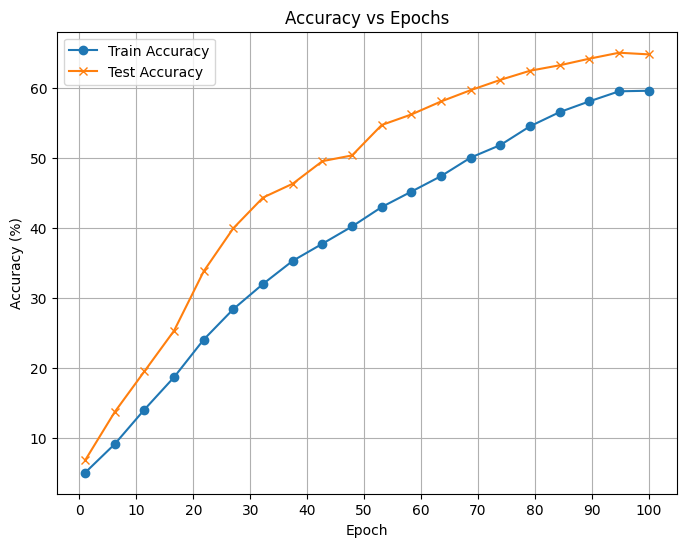

In [33]:
# Instantiate and train a new model
model = FoodCNN().to(device)
model._train_and_save_model()


In [34]:
# Load the best model weights
model = FoodCNN().to(device)  # move model to GPU if available
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()


# calculate and print final test accuracy
final_test_acc = calculate_test_accuracy(model, test_loader)
print(f"Final Test Accuracy: {final_test_acc:.2f}%")

C:\Users\apsne\AppData\Local\Temp\ipykernel_32980\4043900831.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Final Test Accuracy: 64.88%


# Summary of hyperparameters
Report the hyperparameters ( learning rate etc ) that you used in your final model for reproducibility.

### Hyperparameters and Model Architecture Settings Summary

- Learning rate: 0.05 (with cosine annealing scheduler)
- Optimizer: SGD with momentum = 0.9 and weight decay = 1e-4
- Epochs: Up to 100, with early stopping (patience = 5; checked every 5 epochs → triggers after 25 stagnant epochs)
- Evaluation interval: Every 5 epochs
- Batch size: 32
- Loss function: CrossEntropyLoss (with label smoothing = 0.1)
- Dropout: 0.5 (fully connected layers)
- Dropout2d: 0.2 (convolutional layers)
- Label smoothing: 0.1
- Number of convolutional blocks: 4 (VGG-style)
- Kernel size: 3×3 with padding = 1
- Data augmentation: Random resized crop (80–100%), horizontal flip (50%), rotation (±15°), color jitter (±10%), random erasing (25%)
- Architecture: 4 VGG-style convolutional blocks (2 conv + batch norm + ReLU per block), followed by dropout and pooling with increasing filters (64→128→256→512)
- Final layers: Adaptive average pooling → Flatten → Linear(512→256) + ReLU + Dropout(0.5) → Linear(256→91)


# Simulation of random user
Pick 10 random pictures of the test set to simulate a user uploading images and report which categories occur how often in these: 1pt

In [36]:
def user_behaviour_simulation(model):
    model.eval()

    random_indices = random.sample(range(len(test_dataset)), 10)

    true_labels = []
    predicted_labels = []

    for idx in random_indices:
        image, label = test_dataset[idx]
        true_labels.append(label)

        #adjusts an image to be viewed as a batch
        image = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image)
            pred_label = torch.argmax(output, dim=1).item()
            predicted_labels.append(pred_label)

    #maps the indices of the classes to their real names from the dataset
    class_names = test_dataset.classes
    true_class_names = [class_names[i] for i in true_labels]
    pred_class_names = [class_names[i] for i in predicted_labels]

    #stores the classes names with their counts in a separate dictionaries
    true_counts = dict(Counter(true_class_names))
    pred_counts = dict(Counter(pred_class_names))

    #formats output as expected
    print("Predicted Class Frequencies:", pred_counts)
    print("True Class Frequencies:", true_counts)

user_behaviour_simulation(model)

Predicted Class Frequencies: {'cup_cakes': 1, 'onion_rings': 1, 'fried_rice': 1, 'guacamole': 1, 'churros': 1, 'donuts': 1, 'ravioli': 1, 'chocolate_cake': 1, 'greek_salad': 1, 'peking_duck': 1}
True Class Frequencies: {'cup_cakes': 1, 'onion_rings': 1, 'fried_rice': 1, 'nachos': 1, 'french_fries': 1, 'donuts': 1, 'foie_gras': 1, 'chocolate_cake': 1, 'greek_salad': 1, 'peking_duck': 1}


# Bonus point
Use an LLM (API) to generate a description of the food preference of a user based on 10 images that a potential user could provide.
Please include an example of the output of your code, especially if you used an API other than the OpenAI API.

This should work well even with differing test images by setting different random seeds for the image selector.